Some time we have to install a package, if it is not present in goole colaboratory
!pip install packageName

import different required packages

In [9]:

import os
import numpy as np
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2 
import _pickle as cPickle
import pickle


The dataset can be downloaded from 
https://drive.google.com/drive/folders/1ZiGxk6ZN5IBjtNAI4JkJK9YFehS8KNmT?usp=sharing

create a directory and change the current directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

gdrive='/content/drive/'


Mounted at /content/drive


change the myloc path according to your data folder

Let create Training and Testing Dataset

In [ ]:
myloc='MyDrive/shared data/17 Dec 2020/task02/word_traintestset'
rootDir=gdrive+myloc


trainDir=rootDir+'/Train'
trainList=[]
count=0
for path, subdirs, files in os.walk(trainDir):
  for name in files:
    if not name.endswith('.png'):
      continue  
    count = count +1
    imPath=os.path.join(path, name); 
    image=cv2.imread(imPath,0) ### we want to read image as gray
    h,w=image.shape[:2]
    image=cv2.resize(image,(int(w*32/h),32))
    print('Train ',count,image.shape)
    parts=name.split('_');   
    trainList.append([image, parts[0]])
        
      
testDir=rootDir+'/Test'
testList=[]
count=0
for path, subdirs, files in os.walk(testDir):
  for name in files:
    if not name.endswith('.png'):
      continue         
    count = count +1  
    imPath=os.path.join(path, name); 
    image=cv2.imread(imPath,0) ### we want to read image as gray
    h,w=image.shape[:2]
    image=cv2.resize(image,(int(w*32/h),32))
    print('Test',count,image.shape)
    parts=name.split('_');   
    testList.append([image, parts[0]])


      

calculate some statistical information

In [34]:

maxWidth=0
maxLen=0
CharList=[]
for im,word in trainList:
  h,w=im.shape[:2]
  if maxLen<len(word):
    maxLen=len(word)
  if maxWidth<w:
    maxWidth=w
  CharList = list(set(CharList + list(word)))


for im,word in testList:
  h,w=im.shape[:2]
  if maxLen<len(word):
    maxLen=len(word)
  if maxWidth<w:
    maxWidth=w
  CharList = list(set(CharList + list(word)))

with open(rootDir+'/DataSet.pkl', 'wb') as f:
  cPickle.dump([trainList,testList,CharList,maxWidth,maxLen], f, pickle.HIGHEST_PROTOCOL)  

Load Data from saved pickle file

In [35]:
with open(rootDir+'/DataSet.pkl', 'rb') as f:
  trainList,testList,CharList,maxWidth,maxLen = cPickle.load(f)  


class create_dataset(object):
    def __init__(self,CharList,maxWidth,maxLen,batch_size):
      self.CharList=CharList
      self.maxWidth=maxWidth
      self.maxLen=int(maxLen)
      self.numChar=int(len(CharList))
      self.batch_size=batch_size
    def gen(self,dataList, phase='Train'):
        inps=[]
        labels=[]
        label_length=[]
        try:
          while 1:
              shuffle(dataList)
              for img, word in dataList:
                  # print(imPath)
                  tmp=np.zeros((self.maxLen),dtype='int32')
                  for cc,ch in enumerate(word):
                    chi=self.CharList.index(ch)
                    tmp[cc]=int(chi)
                  labels.append(tmp.copy())
                  label_length.append(len(word))

                  tmpimage=np.zeros((32,self.maxWidth),dtype='uint8')             
                  h,w=img.shape[:2]
                  tmpimage[:h,:w]=img
                  inps.append(np.expand_dims(tmpimage,axis=-1))
                  if len(labels)==self.batch_size:            
                      yield np.asarray(inps,dtype='float32'), np.asarray(labels,dtype='int32'), np.asarray(label_length,dtype='int32')
                      inps=[]
                      labels=[]
                      label_length=[]
              if phase=='Test':
                  break
        except GeneratorExit:
          print("Generated Finished")

batch_size=32
# print(len(trainList))
dataset=create_dataset(CharList,maxWidth,maxLen,batch_size)
traindata=dataset.gen(trainList)



Generated Finished


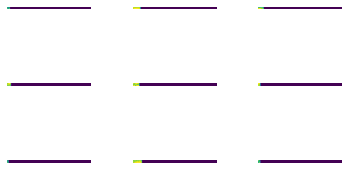

In [36]:
%matplotlib inline

validdata=dataset.gen(testList,phase='Test')
vimages, vclasses, label_length = next( validdata)

# Fill out the subplots with the random images that you defined 
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(vimages[i][:,:,0])
    plt.subplots_adjust(wspace=0.5)
plt.show()

 

In [53]:

# Parameters
learning_rate = 0.01
training_iteration = 100
display_step = 1


# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = [28,28,1] # MNIST data input (img shape: 28*28)
n_classes = dataset.numChar + 1 # MNIST total classes (0-9 digits)

RNNnumKernelList=[128,64]
scInitSize=np.sum(RNNnumKernelList)

initializer=tf.keras.initializers.HeNormal()  
# initializer=tf.keras.initializers.HeUniform()
# initializer = tf.initializers.orthogonal(gain=1.0) 
# initializer = tf.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')  
# initializer = tf.initializers.glorot_uniform()  
# initializer = tf.initializers.glorot_normal()  
# initializer = tf.initializers.RandomUniform(minval=-1.0, maxval=1.0)  
# initializer = tf.initializers.RandomNormal(mean=0, stddev=1.0)  


# Store layers weight & bias
weights = {
    'cnn1': tf.Variable(initializer([3,3,n_input[2],32]),trainable=True),
    'cnn2': tf.Variable(initializer([3,3,32,32]),trainable=True),
    
    
    'cnn3': tf.Variable(initializer([3,3,32,64]),trainable=True),
    'cnn4': tf.Variable(initializer([3,3,64,64]),trainable=True),    
    
    'cnn5': tf.Variable(initializer([3,3,64,64]),trainable=True),

    'WString1':tf.Variable(initializer([4,RNNnumKernelList[0],RNNnumKernelList[0]]), trainable=True),
    'WString2':tf.Variable(initializer([4,RNNnumKernelList[1],RNNnumKernelList[1]]), trainable=True),

    'UString1':tf.Variable(initializer([4,64,RNNnumKernelList[0]]), trainable=True),
    'UString2':tf.Variable(initializer([4,RNNnumKernelList[0],RNNnumKernelList[1]]), trainable=True),
                       
    'h1': tf.Variable(initializer([64*2, n_hidden_1]),trainable=True),
    'h2': tf.Variable(initializer([n_hidden_1, n_hidden_2]),trainable=True),
    'out': tf.Variable(initializer([n_hidden_2, n_classes]),trainable=True)
}
biases = {
    'cb1': tf.Variable(tf.zeros([32]),trainable=True),
    'cb2': tf.Variable(tf.zeros([32]),trainable=True),
    'cb3': tf.Variable(tf.zeros([64]),trainable=True),
    'cb4': tf.Variable(tf.zeros([64]),trainable=True),
    'cb5': tf.Variable(tf.zeros([64]),trainable=True),

    'BString1': tf.Variable(tf.zeros([4,RNNnumKernelList[0]]),trainable=True),
    'BString2': tf.Variable(tf.zeros([4,RNNnumKernelList[1]]),trainable=True),
    
    'b1': tf.Variable(tf.zeros([n_hidden_1]),trainable=True),
    'b2': tf.Variable(tf.zeros([n_hidden_2]),trainable=True),
    'out': tf.Variable(tf.zeros([n_classes]),trainable=True)
}



In [54]:

varList=[]
for key in weights:
  varList.append(weights[key])
for key in biases:
  varList.append(biases[key])


def lstm1Cell(inp,ct_0,ht_0):
  #  forget gate
  fg = tf.sigmoid(tf.matmul(inp, weights['UString1'][0]) + tf.matmul(ht_0,weights['WString1'][0])+ biases['BString1'][0])
  #  input gate
  ig = tf.sigmoid(tf.matmul(inp, weights['UString1'][1]) + tf.matmul(ht_0,weights['WString1'][1]) + biases['BString1'][0])
  
  #  gate weights
  ctg = tf.tanh(tf.matmul(inp, weights['UString1'][2]) + tf.matmul(ht_0,weights['WString1'][2]) + biases['BString1'][0])
  
  #  output gate
  og = tf.sigmoid(tf.matmul(inp, weights['UString1'][3]) + tf.matmul(ht_0,weights['WString1'][3])+ biases['BString1'][0])
  
  ct_i = fg*ct_0 + ig*ctg
  ht_i = og*tf.tanh(ct_i)
  
  return ct_i,ht_i




def lstm2Cell(inp,ct_0,ht_0):
  #  forget gate
  fg = tf.sigmoid(tf.matmul(inp, weights['UString2'][0]) + tf.matmul(ht_0,weights['WString2'][0])+ biases['BString2'][0])
  #  input gate
  ig = tf.sigmoid(tf.matmul(inp, weights['UString2'][1]) + tf.matmul(ht_0,weights['WString2'][1]) + biases['BString2'][0])
  
  #  gate weights
  ctg = tf.tanh(tf.matmul(inp, weights['UString2'][2]) + tf.matmul(ht_0,weights['WString2'][2]) + biases['BString2'][0])
  
  #  output gate
  og = tf.sigmoid(tf.matmul(inp, weights['UString2'][3]) + tf.matmul(ht_0,weights['WString2'][3])+ biases['BString2'][0])
  
  ct_i = fg*ct_0 + ig*ctg
  ht_i = og*tf.tanh(ct_i)
  
  return ct_i,ht_i




def blsmCall(data):
    data = tf.transpose(data,[1,0,2])
    shape=tf.shape(data,out_type=tf.dtypes.int32)
    # init_state_lstmString=tf.zeros((2,shape[1],self.scInitSize))
    
    # step - LSTM
    def stepString(prev, x):
      # gather previous internal state and output state
     
      # iterate through layers
      ht, ct = [], []
      inp = x
      st=0
      
      ############### LSTM 1  ##################
      ct_0,ht_0=tf.unstack(tf.slice(prev,[0,0,st],[-1,-1,RNNnumKernelList[0]]),axis=0)
      ct_i,ht_i=lstm1Cell(inp,ct_0,ht_0)   
      inp = ht_i
      ht.append(ht_i)
      ct.append(ct_i)
      st = st + RNNnumKernelList[0]


      ############### LSTM 2  ##################
      ct_0,ht_0=tf.unstack(tf.slice(prev,[0,0,st],[-1,-1,RNNnumKernelList[1]]),axis=0)
      ct_i,ht_i=lstm2Cell(inp,ct_0,ht_0)  
      inp = ht_i
      ht.append(ht_i)
      ct.append(ct_i)
      st = st + RNNnumKernelList[1]


      return tf.stack([tf.concat(ct,axis=-1), tf.concat(ht,axis=-1)],axis=0)
    
    # tf.print('data ',tf.shape(data))
    # tf.print('upflag ',tf.shape(upflag))
    statesStringF = tf.scan(stepString, data, initializer=tf.zeros((2,shape[1],scInitSize)),name='scanStringF')
    statesStringFct,statesStringFht=tf.unstack(statesStringF,axis=1)
    statesStringFht=tf.split(statesStringFht,RNNnumKernelList,axis=-1)[-1]
    
    
    statesStringB = tf.scan(stepString, tf.reverse(data,[0]), initializer=tf.zeros((2,shape[1],scInitSize)),name='scanStringB')
    statesStringBct,statesStringBht=tf.unstack(statesStringB,axis=1)
    statesStringBht=tf.split(statesStringBht,RNNnumKernelList,axis=-1)[-1]
    statesStringBht= tf.reverse(statesStringBht,[0])
    
    rnnOut= tf.concat([statesStringFht,statesStringBht],axis=-1)
    rnnOut = tf.transpose(rnnOut,[1,0,2])

    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(rnnOut, weights['h1']), biases['b1'])
    layer_1=tf.nn.leaky_relu(layer_1, alpha=0.2)
    #drop1=tf.nn.dropout(layer_1,rate=0.25)
    
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2=tf.nn.leaky_relu(layer_2, alpha=0.2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # out_layer=tf.nn.sigmoid(out_layer)
    y=tf.nn.softmax(out_layer,axis=-1)

    return y




# Create model
def multilayerNN(x):

    cnn1_out=tf.add( tf.nn.conv2d( x, weights['cnn1'], [1,1,1,1], padding='VALID'), biases['cb1'])
    cnn1_actv=tf.nn.leaky_relu(cnn1_out, alpha=0.2)
    
    cnn2_out=tf.add( tf.nn.conv2d( cnn1_actv, weights['cnn2'], [1,1,1,1], padding='VALID'), biases['cb2'])
    cnn2_actv=tf.nn.leaky_relu(cnn2_out, alpha=0.2)
    
    pool1=tf.nn.max_pool(cnn2_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    cnn3_out=tf.add( tf.nn.conv2d( pool1, weights['cnn3'], [1,1,1,1], padding='VALID'), biases['cb3'])
    cnn3_actv=tf.nn.leaky_relu(cnn3_out, alpha=0.2)
    cnn4_out=tf.add( tf.nn.conv2d( cnn3_actv, weights['cnn4'], [1,1,1,1], padding='VALID'), biases['cb4'])
    cnn4_actv=tf.nn.leaky_relu(cnn4_out, alpha=0.2)
    
    pool2=tf.nn.max_pool(cnn4_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    cnn5_out=tf.add( tf.nn.conv2d( pool2, weights['cnn5'], [1,1,1,1], padding='VALID'), biases['cb5'])
    cnn5_actv=tf.nn.leaky_relu(cnn5_out, alpha=0.2)
    
    rnnInp=tf.reduce_max(cnn5_actv,axis=1)


    return rnnInp



optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=10.0**-7)
# optimizer = tf.keras.optimizers.SGD( learning_rate=learning_rate, momentum=0.0)


In [ ]:

iteration=0
while iteration<training_iteration:
  iteration = iteration + 1 
  images, classes, label_length = next(traindata)
       
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.convert_to_tensor(classes)
  label_length=tf.convert_to_tensor(label_length)
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(varList)
    rnnInp = multilayerNN(images)

    y = blsmCall(rnnInp)

    # data = tf.transpose(rnnInp,[1,0,2])
    # shape=tf.shape(data,out_type=tf.dtypes.int32)
    # # init_state_lstmString=tf.zeros((2,shape[1],self.scInitSize))
    
    # # step - LSTM
    # def stepString(prev, x):
    #   # gather previous internal state and output state
     
    #   # iterate through layers
    #   ht, ct = [], []
    #   inp = x
    #   st=0
      
    #   ############### LSTM 1  ##################
    #   ct_0,ht_0=tf.unstack(tf.slice(prev,[0,0,st],[-1,-1,RNNnumKernelList[0]]),axis=0)
    #   ct_i,ht_i=lstm1Cell(inp,ct_0,ht_0)   
    #   inp = ht_i
    #   ht.append(ht_i)
    #   ct.append(ct_i)
    #   st = st + RNNnumKernelList[0]


    #   ############### LSTM 2  ##################
    #   ct_0,ht_0=tf.unstack(tf.slice(prev,[0,0,st],[-1,-1,RNNnumKernelList[1]]),axis=0)
    #   ct_i,ht_i=lstm2Cell(inp,ct_0,ht_0)  
    #   inp = ht_i
    #   ht.append(ht_i)
    #   ct.append(ct_i)
    #   st = st + RNNnumKernelList[1]


    #   return tf.stack([tf.concat(ct,axis=-1), tf.concat(ht,axis=-1)],axis=0)
    
    # # tf.print('data ',tf.shape(data))
    # # tf.print('upflag ',tf.shape(upflag))
    # statesStringF = tf.scan(stepString, data, initializer=tf.zeros((2,shape[1],scInitSize)),name='scanStringF')
    # statesStringFct,statesStringFht=tf.unstack(statesStringF,axis=1)
    # statesStringFht=tf.split(statesStringFht,RNNnumKernelList,axis=-1)[-1]
    
    
    # statesStringB = tf.scan(stepString, tf.reverse(data,[0]), initializer=tf.zeros((2,shape[1],scInitSize)),name='scanStringB')
    # statesStringBct,statesStringBht=tf.unstack(statesStringB,axis=1)
    # statesStringBht=tf.split(statesStringBht,RNNnumKernelList,axis=-1)[-1]
    # statesStringBht= tf.reverse(statesStringBht,[0])
    
    # rnnOut= tf.concat([statesStringFht,statesStringBht],axis=-1)
    # rnnOut = tf.transpose(rnnOut,[1,0,2])
    # )
    # # Hidden fully connected layer with 256 neurons
    # layer_1 = tf.add(tf.matmul(rnnOut, weights['h1']), biases['b1'])
    # layer_1=tf.nn.leaky_relu(layer_1, alpha=0.2)
    # #drop1=tf.nn.dropout(layer_1,rate=0.25)
    
    # # Hidden fully connected layer with 256 neurons
    # layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # layer_2=tf.nn.leaky_relu(layer_2, alpha=0.2)
    # # Output fully connected layer with a neuron for each class
    # out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # # out_layer=tf.nn.sigmoid(out_layer)
    # y=tf.nn.softmax(out_layer,axis=-1)


    shape=tf.shape(y,out_type=tf.dtypes.int32)
    loss = tf.reduce_mean(tf.nn.ctc_loss(classes, y, label_length, shape[1]*tf.ones_like(label_length), logits_time_major=False))
    
  gradients = tape.gradient(loss, varList)
  optimizer.apply_gradients(zip(gradients, varList))

  
  # Display loss per epoch step
  if iteration % display_step == 0:
      print("iteration:", '%04d' % (iteration), "cost={:.9f}".format(loss))

# **Testing**

In [ ]:

with open(rootDir+'/Trainedweights.pkl', 'wb') as f:
  cPickle.dump([weights,biases], f, pickle.HIGHEST_PROTOCOL)  


print(len(testList))
testdata=dataset.gen(testList,phase='Test')

totalN=0
totalP=0
while True:
  try:
    images, classes, label_length = next(testdata)
  except:
    break
  # print(classes)
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.concat(tf.convert_to_tensor(classes),axis=0)
  rnnInp = multilayerNN(images)
  y = blsmCall(rnnInp)
  y=tf.transpose(y,[1,0,2])
  yencoded,log_probability=tf.nn.ctc_beam_search_decoder(y, label_length, beam_width=100, top_paths=1)

  # print(len(yencoded))
  # print(log_probability)
  indices=yencoded[0].indices
  values=tf.cast(yencoded[0].values,dtype='int32')
  dense_shape=yencoded[0].dense_shape

  indices0,indices1=tf.unstack(indices,axis=-1)
  # print('indices ',indices)
  print('indices0 ',indices0)
  # print('indices1 ',indices1)
  print('values ',values)
  # print('dense_shape ',dense_shape)
  
  parts=tf.dynamic_partition( values, tf.cast(indices0,dtype='int32'), 32)
  print(parts)

  p=tf.reduce_sum(tf.cast( tf.equal(values,classes), dtype='float32'))
  totalP = totalP + p
  totalN = totalN + batch_size

  if iteration % display_step == 0:
      print("totalN:", '%04d' % (totalN), "totalP:", '%04d' % (totalP), "Accuracy={:.9f}".format(totalP*100/totalN))